In [4]:
import re
import os
import gc
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from IPython.display import Image
tqdm.pandas()
logging.basicConfig(level=logging.DEBUG)
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [5]:
# Image(filename = "Model_Structure.png")

In [6]:
"""
Load data
"""
df = pd.read_excel('medical_sieve_training_set_lower.xlsx')
df_t = pd.read_excel('medical_sieve_test_set_lower.xlsx')

df.info()
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24603 entries, 0 to 24602
Data columns (total 9 columns):
aspect                    24603 non-null object
course_of_problem         24603 non-null object
group                     24603 non-null object
id                        24603 non-null object
text                      24603 non-null object
trainOrtest               24603 non-null object
treatment                 24603 non-null object
ground_truth_subaspect    24603 non-null object
ground_truth_sentiment    24603 non-null int64
dtypes: int64(1), object(8)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
aspect                    5000 non-null object
course_of_problem         5000 non-null object
group                     5000 non-null object
id                        5000 non-null object
test                      5000 non-null object
text                      5000 non-null object
trainOrtest           

In [7]:
import re
from spellchecker import SpellChecker
sc = SpellChecker()
def process(x):
    ans = set()
    for each in x[1:-1].split(','): 
        words = each.strip().strip('"').strip("'")
        m = re.match('(\w+)-', words)
        if m is not None:
            ans.add(m[1])
#         else:
#             ans.add(words)
    return list(ans)
df['ground_truth_aspect'] = df['ground_truth_subaspect'].apply(lambda x: process(x))
df_t['ground_truth_aspect'] = df_t['ground_truth_subaspect'].apply(lambda x: process(x))

df_dev = df_t[:2500]
df_test = df_t[2500:]

In [8]:
# from random import random
# for index, each in enumerate(df.loc[:]['ground_truth_aspect']):
#     if each == ['not about'] and random() > 0.5 :
#         df = df.drop(index=index)
df['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],17239
1,[access],2797
2,[costs],1613
3,[trusts],1071
4,[errors],1000
5,[delays],857
6,"[access, costs]",14
7,"[trusts, costs]",4
8,"[access, delays]",3
9,"[access, errors]",2


In [9]:
df_t['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],3955
1,[access],356
2,[costs],250
3,[delays],181
4,[trusts],151
5,[errors],107


In [10]:
df_dev['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],1962
1,[access],189
2,[costs],129
3,[delays],86
4,[trusts],81
5,[errors],53


In [11]:
df_test['ground_truth_aspect'].value_counts().reset_index()

,index,ground_truth_aspect
0,[],1993
1,[access],167
2,[costs],121
3,[delays],95
4,[trusts],70
5,[errors],54


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer


mlb_aspect = MultiLabelBinarizer()
mlb_aspect.fit(df['ground_truth_aspect'])
aspect_vectors_train = mlb_aspect.transform(df['ground_truth_aspect'])
aspect_vectors_dev = mlb_aspect.transform(df_dev['ground_truth_aspect'])
aspect_vectors_test = mlb_aspect.transform(df_test['ground_truth_aspect'])
print("Unique types of compliant:\n",mlb_aspect.classes_)

lb_sentiment = LabelBinarizer()
lb_sentiment.fit(list(df['ground_truth_sentiment']) + list(df_t['ground_truth_sentiment']))
sentiment_vectors_train = lb_sentiment.transform(df['ground_truth_sentiment'])
sentiment_vectors_dev = lb_sentiment.transform(df_dev['ground_truth_sentiment'])
sentiment_vectors_test = lb_sentiment.transform(df_test['ground_truth_sentiment'])

print("Unique sentiments: ",lb_sentiment.classes_)
lb_group = LabelBinarizer()
lb_group.fit(list(df['group']) + list(df_t['group']))
group_vectors_train = lb_group.transform(df['group'])
group_vectors_dev = lb_group.transform(df_dev['group'])
group_vectors_test = lb_group.transform(df_test['group'])

Unique types of compliant:
 ['access' 'costs' 'delays' 'errors' 'trusts']
Unique sentiments:  [0 1 2]


0    16851
1     7506
2      246
Name: ground_truth_sentiment, dtype: int64


Text(0, 0.5, 'count')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDis

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal heavy normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 2.777272727272727
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/jaden/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-BoldItalic.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInter

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-HeavyItalic.otf) italic normal heavy normal>) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS Bold.ttf) normal normal bold normal>) = 10.335

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-SemiboldItalic.otf) italic normal semibold normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText-Heavy.otf) normal normal heavy normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/jaden/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


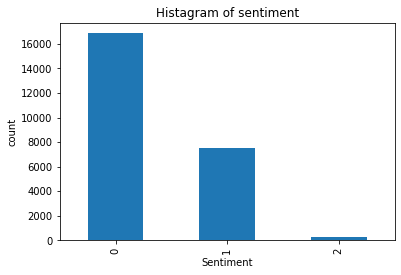

In [13]:
print(df['ground_truth_sentiment'].value_counts())
df['ground_truth_sentiment'].value_counts().plot.bar()
plt.title('Histagram of sentiment')
plt.xlabel('Sentiment')
plt.ylabel('count')

Text(0, 0.5, 'count')

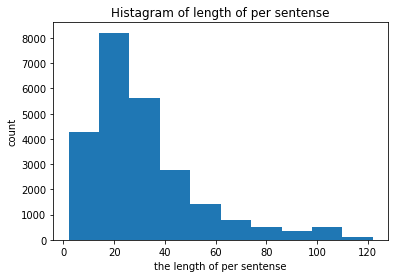

In [14]:
df['text'].apply(lambda x: len(x.split())).hist(grid=False)
plt.title('Histagram of length of per sentense')
plt.xlabel('the length of per sentense')
plt.ylabel('count')

In [15]:
MAX_SEQUENCE_LEN = 128
MAX_FEATURES = 489618
ASPECT_OUTPUT_DIM = len(mlb_aspect.classes_)
SENTIMENT_OUT_DIM = len(lb_sentiment.classes_)
GROUP_DIM = len(lb_group.classes_)
print("aspect_out_put: {}, senntiment_out_put: {}, group_dim: {}".format(ASPECT_OUTPUT_DIM, SENTIMENT_OUT_DIM, GROUP_DIM))

aspect_out_put: 5, senntiment_out_put: 3, group_dim: 277


In [16]:
"""
Fit tokenizer
"""
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
logging.info("Fitting Tokenizer")


# Updates internal vocabulary based on a list of texts
whole_text = []
with open('medical_sieve_sentence_corpus.txt', 'r') as f:
    for each in f.readlines():
        whole_text.append(each.strip())
f.close()
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True, filters='"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(whole_text)

logging.info("Beginning process train text")
train_text = tokenizer.texts_to_sequences(df['text'])
aa = train_text
train_text = pad_sequences(train_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process dev text")
dev_text = tokenizer.texts_to_sequences(df_dev['text'])
dev_text = pad_sequences(dev_text, maxlen=MAX_SEQUENCE_LEN)

logging.info("Beginning process test text")
test_text = tokenizer.texts_to_sequences(df_test['text'])
test_text = pad_sequences(test_text, maxlen=MAX_SEQUENCE_LEN)

Using TensorFlow backend.
INFO:root:Fitting Tokenizer
INFO:root:Beginning process train text
INFO:root:Beginning process dev text
INFO:root:Beginning process test text


In [17]:
word_index = tokenizer.word_index
print('The number of unique words:', len(word_index))
del tokenizer
gc.collect()

The number of unique words: 389625


20

In [18]:
"""
Get word Embedding
"""
EMB_PATH = "cbow_model_medical_sieve_lower.vec"
EMBEDDING_DIM = 300

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir=EMB_PATH):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

# EMB_PATH  = "glove.840B.300d.txt"
# EMBEDDING_DIM = 300

# def load_embeddings(embedding_path=EMB_PATH):
#     '''return a dict whose key is word, value is pretrained word embedding'''
#     embeddings_index = {}
#     f = open(embedding_path, 'r', encoding='utf-8')
#     for line in f:
#         values = line.split()
#         try:
#             word = values[0]
#             coefs = np.asarray(values[1:], dtype='float32')
#             embeddings_index[word] = coefs
#         except:
#             print("Err on ", values[:2])
#     f.close()
#     print('Total %s word vectors.' % len(embeddings_index))
#     return embeddings_index

def build_matrix(word_index, embeddings_index):
    count = 0
    embedding_matrix = np.zeros((len(word_index) + 1,EMBEDDING_DIM))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            count += 1
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix, count

In [19]:
embeddings_index = load_embeddings()
embedding_matrix, count = build_matrix(word_index, embeddings_index)
print("The number of words that FastText drops:", count)
del embeddings_index
gc.collect()

92302it [00:05, 18034.48it/s]


The number of words that FastText drops: 304327


20

In [20]:
from keras.engine import InputSpec, Layer
from keras import initializers
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.W]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [21]:
"""
Model builder
"""

from keras.layers import SpatialDropout1D, Bidirectional, Dense, LSTM
from keras.layers import Conv1D, Flatten, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Lambda
from keras.layers import concatenate
from keras.layers import Input, Embedding, Concatenate
from keras.models import Model
from keras.optimizers import Adagrad, Adam
from bpmll import bp_mll_loss
from keras import backend as K
from keras import optimizers

def build_model(verbose = True, compile = True):
    recurrent_units = 64
    input_layer = Input(shape=(MAX_SEQUENCE_LEN,))
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LEN,
                                trainable=False)(input_layer)
    embedding_layer = SpatialDropout1D(0.25)(embedding_layer)

    rnn_1 = Bidirectional(LSTM(recurrent_units, return_sequences=True))(embedding_layer)
    rnn_2 = Bidirectional(LSTM(recurrent_units, return_sequences=True))(rnn_1)
    x = concatenate([rnn_1, rnn_2], axis=2)

    last = Lambda(lambda t: t[:, -1], name='last')(x)
    maxpool = GlobalMaxPooling1D()(x)
    attn = AttentionWeightedAverage()(x)
    average = GlobalAveragePooling1D()(x)

    all_views = concatenate([last, maxpool, average, attn], axis=1)
    x = Dropout(0.5)(all_views)
    x = Dense(144, activation="relu")(x)
    output_layer = Dense(ASPECT_OUTPUT_DIM, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6, clipvalue=5)
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [45]:
"""
Training Session
"""
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

BATCH_SIZE = 256
NUM_EPOCHS = 100


# class_weights = class_weight.compute_class_weight('balanced', mlb_aspect.classes_, df['ground_truth_aspect'].apply(lambda x: x[0]))

K.clear_session()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath="Pooled_RNN_ASPECT_weight"+str(BATCH_SIZE)+".hdf5", verbose=1, save_best_only=True)
model = build_model()
model.fit(x = train_text,
          y = aspect_vectors_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          validation_data = (dev_text,
                             aspect_vectors_dev),
          callbacks = [reduce_lr, es, checkpointer]
#           class_weight=class_weights
         )
model.load_weights("Pooled_RNN_ASPECT_weight"+str(BATCH_SIZE)+".hdf5")
# test_preds /= 5

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     116887800   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 128)     186880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

In [46]:
import copy
def combinations(nums):
    ans = [[]]
    for row in nums:
        curr = []
        for combination in ans:
            for element in row:
                new_combination = copy.deepcopy(combination)
                new_combination.append(element)
                curr.append(new_combination)
        ans = curr
    return ans
thresholds = [[0.2, 0.25, 0.3, 0.4, 0.45, 0.5, 0.55] for each in range(5)]
thresholds_set = combinations(thresholds)

In [59]:
val_preds = model.predict(dev_text)
aspect_vectors = aspect_vectors_dev

In [48]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score

def f1(matrix):
    precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
    recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
    return 2*((precision*recall)/(precision+recall))

max_avg_f1 = 0
max_hamming_score = 0
max_exact_accuracy = 0
max_fuzzy_accuracy = 0
max_fuzzy_accuracy_pos = 0
max_exact_accuracy_pos = 0
max_avg_rocauc = 0
max_confusion_matrix = None
max_threshold_set = []

for threshold_set in thresholds_set:
    predict_softmax = np.zeros(aspect_vectors.shape, dtype=int)
    for row_index, row in enumerate(val_preds):
        for index, each in enumerate(row):
            if each >= threshold_set[index]:
                predict_softmax[row_index][index] = 1

    hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors) 
    num_fuzzy_match = 0
    num_fuzzy_match_pos = 0
    num_exact_match_pos = 0
    num_pos = 0
    for true, pre in zip(mlb_aspect.inverse_transform(aspect_vectors), mlb_aspect.inverse_transform(predict_softmax)):
        if len(true) != 0: 
            num_pos += 1
        intersect = set(pre).intersection(set(true))
        if (len(true)>0 and len(pre)>0 and len(intersect) > 0) or (len(true) == 0 and len(pre) == 0):
            num_fuzzy_match += 1
        if len(true)>0 and len(pre)>0 and len(intersect) > 0:
            num_fuzzy_match_pos += 1
        if len(true)>0 and len(pre)>0 and pre == true: 
            num_exact_match_pos += 1
    fuzzy_accuracy = num_fuzzy_match*1.0/len(predict_softmax)
    exact_accuracy = accuracy_score(predict_softmax, aspect_vectors)
    fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
    exact_accuracy_pos = num_exact_match_pos*1.0/num_pos


    class_f1 = []
    for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors, predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
        class_f1.append(f1(confusion_matrix))
        
    rocauc_score = roc_auc_score(aspect_vectors, val_preds, 'weighted')
    if np.mean(class_f1) > max_avg_f1:
        max_threshold_set = threshold_set
        max_avg_f1 = max(max_avg_f1, np.mean(class_f1))
        max_hamming_score = hamming_score
        max_exact_accuracy = exact_accuracy
        max_fuzzy_accuracy = fuzzy_accuracy 
        max_exact_accuracy_pos = exact_accuracy_pos
        max_fuzzy_accuracy_pos = fuzzy_accuracy_pos
        max_avg_rocauc = rocauc_score
        max_confusion_matrix = multilabel_confusion_matrix(aspect_vectors, predict_softmax)
        
        

print("threshold set:", max_threshold_set)
print("Confusion Matrix for Each Aspect:\n" + "="*60)
print(max_confusion_matrix)
print("Result of Metrics for Evaluation:\n" + "="*60)
print("Hamming score:", max_hamming_score)
print("Exact accuracy:", max_exact_accuracy)
print("Fuzzy accuracy:", max_fuzzy_accuracy)
print("Exact accuracy (exclude negative):", max_exact_accuracy_pos )
print("Fuzzy accuracy (exclude negative):", max_fuzzy_accuracy_pos)
print("Average F1 Score: ", max_avg_f1)
print("ROC AUC Score: ", max_avg_rocauc)

threshold set: [0.45, 0.55, 0.55, 0.45, 0.25]
Confusion Matrix for Each Aspect:
[[[2177  134]
  [  34  155]]

 [[2313   58]
  [  33   96]]

 [[2378   36]
  [  40   46]]

 [[2405   42]
  [  24   29]]

 [[2293  126]
  [  25   56]]]
Result of Metrics for Evaluation:
Hamming score: 0.95584
Exact accuracy: 0.7908
Fuzzy accuracy: 0.7928
Exact accuracy (exclude negative): 0.7007434944237918
Fuzzy accuracy (exclude negative): 0.7100371747211895
Average F1 Score:  0.5536394581892877
ROC AUC Score:  0.9619562343909684


In [60]:
np.savetxt('Pooled_RNN_Aspect_dev_predict.txt', val_preds, delimiter=' ')

In [61]:
val_preds = model.predict(test_text)
aspect_vectors = aspect_vectors_test

In [51]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score

def f1(matrix):
    precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
    recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
    return 2*((precision*recall)/(precision+recall))

max_avg_f1 = 0
max_hamming_score = 0
max_exact_accuracy = 0
max_fuzzy_accuracy = 0
max_fuzzy_accuracy_pos = 0
max_exact_accuracy_pos = 0
max_avg_rocauc = 0
max_confusion_matrix = None
max_threshold_set = []

for threshold_set in thresholds_set:
    predict_softmax = np.zeros(aspect_vectors.shape, dtype=int)
    for row_index, row in enumerate(val_preds):
        for index, each in enumerate(row):
            if each >= threshold_set[index]:
                predict_softmax[row_index][index] = 1

    hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors) 
    num_fuzzy_match = 0
    num_fuzzy_match_pos = 0
    num_exact_match_pos = 0
    num_pos = 0
    for true, pre in zip(mlb_aspect.inverse_transform(aspect_vectors), mlb_aspect.inverse_transform(predict_softmax)):
        if len(true) != 0: 
            num_pos += 1
        intersect = set(pre).intersection(set(true))
        if (len(true)>0 and len(pre)>0 and len(intersect) > 0) or (len(true) == 0 and len(pre) == 0):
            num_fuzzy_match += 1
        if len(true)>0 and len(pre)>0 and len(intersect) > 0:
            num_fuzzy_match_pos += 1
        if len(true)>0 and len(pre)>0 and pre == true: 
            num_exact_match_pos += 1
    fuzzy_accuracy = num_fuzzy_match*1.0/len(predict_softmax)
    exact_accuracy = accuracy_score(predict_softmax, aspect_vectors)
    fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
    exact_accuracy_pos = num_exact_match_pos*1.0/num_pos


    class_f1 = []
    for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors, predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
        class_f1.append(f1(confusion_matrix))
        
    rocauc_score = roc_auc_score(aspect_vectors, val_preds, 'weighted')
    if np.mean(class_f1) > max_avg_f1:
        max_threshold_set = threshold_set
        max_avg_f1 = max(max_avg_f1, np.mean(class_f1))
        max_hamming_score = hamming_score
        max_exact_accuracy = exact_accuracy
        max_fuzzy_accuracy = fuzzy_accuracy 
        max_exact_accuracy_pos = exact_accuracy_pos
        max_fuzzy_accuracy_pos = fuzzy_accuracy_pos
        max_avg_rocauc = rocauc_score
        max_confusion_matrix = multilabel_confusion_matrix(aspect_vectors, predict_softmax)
        
        

print("threshold set:", max_threshold_set)
print("Confusion Matrix for Each Aspect:\n" + "="*60)
print(max_confusion_matrix)
print("Result of Metrics for Evaluation:\n" + "="*60)
print("Hamming score:", max_hamming_score)
print("Exact accuracy:", max_exact_accuracy)
print("Fuzzy accuracy:", max_fuzzy_accuracy)
print("Exact accuracy (exclude negative):", max_exact_accuracy_pos )
print("Fuzzy accuracy (exclude negative):", max_fuzzy_accuracy_pos)
print("Average F1 Score: ", max_avg_f1)
print("ROC AUC Score: ", max_avg_rocauc)

threshold set: [0.45, 0.3, 0.3, 0.55, 0.4]
Confusion Matrix for Each Aspect:
[[[2143  190]
  [  25  142]]

 [[2302   77]
  [  21  100]]

 [[2350   55]
  [  33   62]]

 [[2414   32]
  [  20   34]]

 [[2368   62]
  [  38   32]]]
Result of Metrics for Evaluation:
Hamming score: 0.9557599999999999
Exact accuracy: 0.79
Fuzzy accuracy: 0.792
Exact accuracy (exclude negative): 0.7199211045364892
Fuzzy accuracy (exclude negative): 0.7297830374753451
Average F1 Score:  0.5564190891266942
ROC AUC Score:  0.9553456091806286


In [68]:
predict_softmax = np.zeros(aspect_vectors.shape, dtype=int)
for row_index, row in enumerate(val_preds):
    for index, each in enumerate(row):
        if each >= 0.3:
            predict_softmax[row_index][index] = 1

hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors) 
num_fuzzy_match = 0
num_fuzzy_match_pos = 0
num_exact_match_pos = 0
num_pos = 0
for true, pre in zip(mlb_aspect.inverse_transform(aspect_vectors), mlb_aspect.inverse_transform(predict_softmax)):
    if len(true) != 0: 
        num_pos += 1
    intersect = set(pre).intersection(set(true))
    if (len(true)>0 and len(pre)>0 and len(intersect) > 0) or (len(true) == 0 and len(pre) == 0):
        num_fuzzy_match += 1
    if len(true)>0 and len(pre)>0 and len(intersect) > 0:
        num_fuzzy_match_pos += 1
    if len(true)>0 and len(pre)>0 and pre == true: 
        num_exact_match_pos += 1
fuzzy_accuracy = num_fuzzy_match*1.0/len(predict_softmax)
exact_accuracy = accuracy_score(predict_softmax, aspect_vectors)
fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
exact_accuracy_pos = num_exact_match_pos*1.0/num_pos


class_f1 = []
for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors, predict_softmax)):
    print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
    class_f1.append(f1(confusion_matrix))

rocauc_score = roc_auc_score(aspect_vectors, val_preds, 'weighted')
       

print("Confusion Matrix for Each Aspect:\n" + "="*60)
print(confusion_matrix)
print("Result of Metrics for Evaluation:\n" + "="*60)
print("Hamming score:", hamming_score)
print("Exact accuracy:", exact_accuracy)
print("Fuzzy accuracy:", fuzzy_accuracy)
print("Exact accuracy (exclude negative):", exact_accuracy_pos )
print("Fuzzy accuracy (exclude negative):", fuzzy_accuracy_pos)
print("Average F1 Score: ", np.mean(class_f1))
print("ROC AUC Score: ", rocauc_score)

access : 0.5578747628083491 
 [[2120  213]
 [  20  147]] 

costs : 0.6711409395973155 
 [[2302   77]
 [  21  100]] 

delays : 0.5849056603773585 
 [[2350   55]
 [  33   62]] 

errors : 0.4772727272727273 
 [[2366   80]
 [  12   42]] 

trusts : 0.3827751196172249 
 [[2331   99]
 [  30   40]] 

Confusion Matrix for Each Aspect:
[[2331   99]
 [  30   40]]
Result of Metrics for Evaluation:
Hamming score: 0.9488
Exact accuracy: 0.7568
Fuzzy accuracy: 0.7592
Exact accuracy (exclude negative): 0.7593688362919132
Fuzzy accuracy (exclude negative): 0.7712031558185405
Average F1 Score:  0.5347938419345951
ROC AUC Score:  0.9553456091806286


In [62]:
np.savetxt('Pooled_RNN_Aspect_test_predict.txt', val_preds, delimiter=' ')

In [37]:
"""
Training Session
"""
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

BATCH_SIZE = 512
NUM_EPOCHS = 100
FOLDER_NUM = 5

# class_weights = class_weight.compute_class_weight('balanced', lb_sentiment.classes_, df['ground_truth_sentiment'])

# splits = list(KFold(n_splits=FOLDER_NUM).split(train_text, aspect_vectors))
splits = list(KFold(n_splits=FOLDER_NUM).split(train_text, aspect_vectors_train))

# test_preds = np.zeros((test_text.shape[0]))
folders = [i for i in range(FOLDER_NUM)]
train_val_preds = np.zeros((aspect_vectors_train.shape))
dev_preds = np.zeros((aspect_vectors_dev.shape))
test_preds = np.zeros((aspect_vectors_test.shape))

for folder in folders:
    K.clear_session()
    train_index, validate_index = splits[folder]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, mode='min', verbose=1)
#     checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
    model = build_model()
    model.fit(x = train_text[train_index],
              y = aspect_vectors_train[train_index],
              batch_size = BATCH_SIZE,
              epochs = NUM_EPOCHS,
              validation_data = (train_text[validate_index],
                                 aspect_vectors_train[validate_index]),
              callbacks = [reduce_lr, es]
#               class_weight=class_weights
             )
    train_val_preds[validate_index] = model.predict(train_text[validate_index])
    dev_preds += model.predict(dev_text)
    test_preds += model.predict(test_text)
dev_preds /= FOLDER_NUM
test_preds /= FOLDER_NUM

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     116887800   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128, 128)     186880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

Train on 19682 samples, validate on 4921 samples
Epoch 1/100
19682/19682 [==============================] - 105s 5ms/step - loss: 0.2586 - acc: 0.9306 - val_loss: 0.2105 - val_acc: 0.9403
Epoch 2/100
19682/19682 [==============================] - 98s 5ms/step - loss: 0.2042 - acc: 0.9399 - val_loss: 0.1766 - val_acc: 0.9415
Epoch 3/100
19682/19682 [==============================] - 99s 5ms/step - loss: 0.1705 - acc: 0.9423 - val_loss: 0.1459 - val_acc: 0.9470
Epoch 4/100
19682/19682 [==============================] - 98s 5ms/step - loss: 0.1453 - acc: 0.9479 - val_loss: 0.1270 - val_acc: 0.9510
Epoch 5/100
19682/19682 [==============================] - 98s 5ms/step - loss: 0.1283 - acc: 0.9523 - val_loss: 0.1186 - val_acc: 0.9535
Epoch 6/100
19682/19682 [==============================] - 99s 5ms/step - loss: 0.1182 - acc: 0.9553 - val_loss: 0.1107 - val_acc: 0.9574
Epoch 7/100
19682/19682 [==============================] - 98s 5ms/step - loss: 0.1081 - acc: 0.9587 - val_loss: 0.1144 - 

19682/19682 [==============================] - 101s 5ms/step - loss: 0.0848 - acc: 0.9661 - val_loss: 0.0976 - val_acc: 0.9608
Epoch 14/100
19682/19682 [==============================] - 101s 5ms/step - loss: 0.0800 - acc: 0.9681 - val_loss: 0.0978 - val_acc: 0.9603
Epoch 15/100
19682/19682 [==============================] - 101s 5ms/step - loss: 0.0774 - acc: 0.9685 - val_loss: 0.0982 - val_acc: 0.9594
Epoch 16/100
19682/19682 [==============================] - 101s 5ms/step - loss: 0.0743 - acc: 0.9699 - val_loss: 0.0994 - val_acc: 0.9578

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 17/100
19682/19682 [==============================] - 101s 5ms/step - loss: 0.0708 - acc: 0.9707 - val_loss: 0.0981 - val_acc: 0.9603
Epoch 18/100
19682/19682 [==============================] - 102s 5ms/step - loss: 0.0680 - acc: 0.9723 - val_loss: 0.0981 - val_acc: 0.9607
Epoch 00018: early stopping
________________________________________________________________

Train on 19683 samples, validate on 4920 samples
Epoch 1/100
19683/19683 [==============================] - 107s 5ms/step - loss: 0.2587 - acc: 0.9278 - val_loss: 0.2161 - val_acc: 0.9381
Epoch 2/100
19683/19683 [==============================] - 98s 5ms/step - loss: 0.2030 - acc: 0.9404 - val_loss: 0.1884 - val_acc: 0.9396
Epoch 3/100
19683/19683 [==============================] - 98s 5ms/step - loss: 0.1740 - acc: 0.9417 - val_loss: 0.1572 - val_acc: 0.9451
Epoch 4/100
19683/19683 [==============================] - 98s 5ms/step - loss: 0.1496 - acc: 0.9460 - val_loss: 0.1404 - val_acc: 0.9470
Epoch 5/100
19683/19683 [==============================] - 99s 5ms/step - loss: 0.1325 - acc: 0.9503 - val_loss: 0.1251 - val_acc: 0.9524
Epoch 6/100
19683/19683 [==============================] - 99s 5ms/step - loss: 0.1209 - acc: 0.9542 - val_loss: 0.1160 - val_acc: 0.9546
Epoch 7/100
19683/19683 [==============================] - 99s 5ms/step - loss: 0.1120 - acc: 0.9566 - val_loss: 0.1123 - 

In [58]:
np.savetxt('Pooled_RNN_Aspect_training_predict.txt', train_val_preds, delimiter=' ')

In [27]:
# from sklearn.metrics import hamming_loss
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import multilabel_confusion_matrix
# for threshold in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
#     print('*'*20)
#     print("Threshold:", threshold)
#     print('*'*20)
#     predict_softmax = np.zeros(aspect_vectors_train[validate_index].shape, dtype=int)
#     for row_index, row in enumerate(val_preds):
#         for index, each in enumerate(row):
#             if each > 0.09:
#                 predict_softmax[row_index][index] = 1

#     hamming_score = 1 - hamming_loss(predict_softmax, aspect_vectors_train[validate_index]) 
#     acc = accuracy_score(predict_softmax, aspect_vectors_train[validate_index])
#     fuzzy_acc = 0
#     for pre, true, in zip(mlb_aspect.inverse_transform(predict_softmax), mlb_aspect.inverse_transform(aspect_vectors_train[validate_index])):
#         intersect = set(pre).intersection(set(true))
#         if intersect != None and len(intersect) > 0:
#             fuzzy_acc += 1
#     fuzzy_acc = fuzzy_acc*1.0 / len(predict_softmax)
#     print("hamming score:", hamming_score)
#     print("exact accuracy:", acc)
#     print("fuzzy accuracy:", fuzzy_acc)


#     def f1(matrix):
#         precision = matrix[1][1]*1.0 / (matrix[0][1] + matrix[1][1])
#         recall = matrix[1][1]*1.0 / (matrix[1][0] + matrix[1][1])
#         return 2*((precision*recall)/(precision+recall))
#     class_f1 = []
#     for aspect, confusion_matrix in zip(mlb_aspect.classes_, multilabel_confusion_matrix(aspect_vectors_train[validate_index], predict_softmax)):
#         print(aspect, ':',f1(confusion_matrix),'\n', confusion_matrix, '\n')
#         class_f1.append(f1(confusion_matrix))
#     print("average f1 score: ", np.mean(class_f1))